# CSI5139
* * *
# Assignment 1 | Image Labelling - Linear Classification
* * * 

### In this jupyter notebook, I will be discussing the following:
1. Generic data gathering from the dataset directories
2. Data preparation and preprocessing (RGB images to grayscale images, image rescaling, image falttening)
3. Visualizing random images from the data set
4. Binary Classifier
    1. train/val/test sets splits
    - Performance metrics (accuracy, percision, recall, confusion matrix, ROC curve)
* * * 

### Getting started by imporing the libraries that I will be using throughout my assignment
- os -> reading and manipulating the file system (files and directories)
- skimage -> for using built-in functions for image pre-processing (rgb2gray, rescale, etc.)
- numpy -> for optimized numerical containers and computations
- ntpath -> to manipulate the string of a directory's path

In [1]:
%matplotlib inline
import os
import skimage
from skimage.transform import rescale, resize
import matplotlib
import matplotlib.pyplot as plt
import ntpath
import numpy as np

### Defining some global varibales

In [2]:
# Global Variables
DATASET_DIRNAME = "Phos2_0_2MP"
RESCALING_FACTOR = 1. / 5.
NONUNI_KEYWORDS = ["_nonuni_"]
UNI_KEYWORDS = ["_uni_"]

### Since I want my implementation to be as generic and reusable as possible, I have implemented some helper functions that I will be using to gather and prepare the images from the dataset's folders.

#### Here are a set of function that I thought will help me to acheive a certain level of reusability
1. Function that returns all the subdirectories in a given directory.
2. Function that returns all the images' paths that has a specific extension in a given directory .
3. Function that returns an image as a numpy array given the image's path.
4. Function that rescales an image (if applicable).
5. Function that flattens an image (e.g. (5, 5, 3) -> (5 * 5 * 3)) (if applicable).
6. Function that tranforms an RGB image to grayscal (if applicable).
7. Finally, a function that takes advantage of all the above functions in order to read all the images in the data set.

### By doing that, we will have ONE a high-level API function that is responsible for gathering and preparing the images within a dataset directories (not just for this dataset, it can also work with any other dataset with the same structure), that is given only the dataset directory name, and some options to follow (image color channel, rescaling factor, etc.) 

This function returns a list of all subdirectories of a given directory name as a function parameter.

In [3]:
# returns a list of subdirectories under a specific directory
def get_subdirectories(dir_name):
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, subdir_name) for subdir_name in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, subdir_name))]
    else:
        return []

This function returns a list of all images' files that have '.png' extension of a given directory name as a function parameter.

In [4]:
# returns a list of all image files ending with '.png' in that specific directory
def get_files_within_dir(dir_name):
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, file_name) for file_name in os.listdir(dir_name) if file_name.endswith('.png')]
    else:
        return []

This function returns a list of tuples, each pair is consisting of (rescaled image, original size of the image, path of the image). <br>
It takes one mandatory function parameters which is the rescaling factor that will be performed over the image. <br>
It takes some optional function parameters as: whether the image should be returned as RGB or grayscal, whether the image data should be flattened or not.

In [5]:
# gets a list of images' filenames, rescaling factor, and either the images will be RGB or grayscale
# returns a pair (image's np.ndarray either RGB or grayscale, filename)
def read_images_from_files(filenames, rescale_factor, rgb=True, flatten=False):
    # get a single image's filename to read it
    # returns the rescaled image
    def read_image_from_file(filename):
        img = skimage.io.imread(filename)
        org_size = img.shape
        img = rescale(img, rescale_factor, anti_aliasing=True)
        
        if (rgb == False):
            img = skimage.color.rgb2gray(img)
        
        if (flatten==True):
            img = img.flatten()
        return img, org_size
        
    images = []
    for filename in filenames:
        img, org_size = read_image_from_file(filename)
        images.append((img, org_size, filename))
    return images

This function uses all the functions above to return all the images given the dataset directory name as a function parameter. <br>
It also takes one mandatory function parameter which is the rescaling factor that will be perfomed over the image data. <br>
It takes two other optional parameters which are whether the images will be returned as RGB or grascale, and the images will be flattened or not.

In [6]:
# get dataset directory name, rescaling factor to be applied for all the images and whether the dataset will be RGB or grayscale
# return a list of all images found along with each image filename
def get_all_images(dataset_dirname, rescale_factor, RGB=True, flatten=False):
    subdirectories = get_subdirectories(dataset_dirname)
    all_images = []
    for subdir in subdirectories:
        images_filenames = get_files_within_dir(subdir)
        subdir_images = read_images_from_files(filenames=images_filenames, rescale_factor=rescale_factor, rgb=RGB, flatten=flatten)
        all_images += subdir_images
    return all_images

This function is very important for any dataset that is labeled by a file naming convention. <br>
It simply gatheres images based on the presence of some keywords in these images' filenames.

In [7]:
def get_images_by_keywords(all_images, keywords):
    
    def keywords_found(filename):
        found = True
        image_filename = ntpath.basename(filename)
        for keyword in keywords:
            found = (found and (keyword in image_filename))
        return found
    
    images = [image[0] for image in all_images if keywords_found(image[2]) == True]
    org_sizes = [image[1] for image in all_images if keywords_found(image[2]) == True]
    return images, org_sizes

Now we are ready to use the ***get_all_images*** function to get all the dataset images, sizes and filenames in one list.

In [8]:
grayscale_data = get_all_images(DATASET_DIRNAME, RESCALING_FACTOR, RGB=False, flatten=True)

c:\users\administrator\anaconda3\envs\ottawa\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


This function simply generates a list with a specific length and a constant value for all the list elements.

In [9]:
def generate_labels_list(list_len, label):
    return np.full(list_len, label).tolist()

Now we can use the ***get_images_by_keywords*** function to get the images based on their illumination, e.g. uniform and non-uniform images. <br>
We always need the original sizes of the images for the purpose of visualizing the data.

In [10]:
# defining the non-uniform images and labels
nonuni_images, nonuni_org_sizes = get_images_by_keywords(grayscale_data, NONUNI_KEYWORDS)
nonuni_labels = generate_labels_list(len(nonuni_images), 0)
# defining the uniform images and labels
uni_images, uni_org_sizes = get_images_by_keywords(grayscale_data, UNI_KEYWORDS)
uni_labels = generate_labels_list(len(uni_images), 1)
# defining length of the data
nonuni_len = len(nonuni_images)
uni_len = len(uni_images)

In [11]:
print("Number of examples on non-uniform illumination pictures is: " + str(nonuni_len) + " with label " + str(nonuni_labels[0]))
print("Number of examples on uniform illumination pictures is: " + str(uni_len) + " with label " + str(uni_labels[0]))

Number of examples on non-uniform illumination pictures is: 90 with label 0
Number of examples on uniform illumination pictures is: 135 with label 1


This function simply plots an image and puts a title on that image.

In [12]:
def plot_image(image, title=None):
    plt.title(title)
    plt.imshow(image,
               cmap = matplotlib.cm.binary,
               interpolation="nearest")

''' 
    plotting a random image from the images with non-uniform illumination
    first we generate a random index bounded by the non-uniform illumination images data length
    then we get that image's original size
    then we rescale that size using the golbally defined RESCALING FACTOR
    then we reshape the random image using that rescaled shape
    finally we plot the image
'''
def plot_random_image(image_list, label_list, org_size_list):
    if (len(image_list) == len(label_list) and len(label_list) == len(org_size_list)):
        rand_idx = np.random.randint(low=0, high=len(image_list)-1)
        org_size = org_size_list[rand_idx]
        rescaled_shape = (int(org_size[0] * RESCALING_FACTOR), int(org_size[1] * RESCALING_FACTOR))
        plot_image(image_list[rand_idx].reshape(rescaled_shape), "Class " + str(label_list[rand_idx]))
    else:
        return None

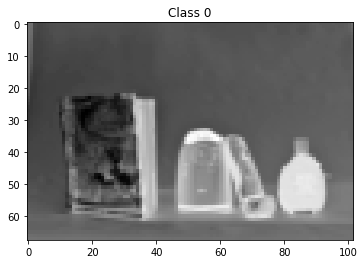

In [13]:
plot_random_image(nonuni_images, nonuni_labels, nonuni_org_sizes)

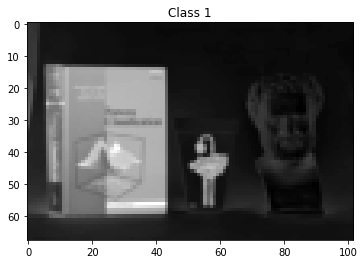

In [14]:
plot_random_image(uni_images, uni_labels, uni_org_sizes)

### Now we construct the X (input), y (ground truth data) by adding the uniform and non-uniform images and labels lists 

In [15]:
# defining the dataset's X (input) and y (groundtruth)
X = np.asarray(uni_images + nonuni_images)
y = np.asarray(uni_labels + nonuni_labels)
# defining original sizes array
# we need that in case we will plot an image within the all the data combined
org_sizes = uni_org_sizes + nonuni_org_sizes

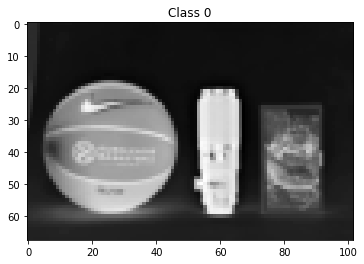

In [16]:
plot_random_image(X, y, org_sizes)

This function simply generates a random permutation of the size given as N.

In [17]:
def get_random_permutation(n):
    return np.random.permutation(n)
p = get_random_permutation(len(X))

Now we are ready to use the function ***shuffle_data*** to shuffle our X and y numpy ndarrays.

In [18]:
shuffled_X, shuffled_y = X[p], y[p]

Now it is time to split the data into separate training and testing sets. <br>
For the splits size, I am going to split it 80% of the data for training and 20% is for testing. <br>
Thus we have 180 images for training the linear model, and 45 images for testing its performance. <br>

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_y, test_size=0.2)

In [20]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=False)

## Binary Classifier
***
Here I am going to use LogisticRegressionCV class provided by sklearn to train it to predict the illumination class of my data. <br>
The LogisticRegressionCV class takes *cv* as a parameter, and it is a cross-validation generator. <br>
I am going to train the model two times, one with stratisfied sampling and one without it.

First, training a linear classifier with stratisfied k-fold cross-validation

In [21]:
from sklearn.linear_model import LogisticRegressionCV

bin_clf = LogisticRegressionCV(max_iter=40, tol=0.01, cv=skfold, solver='liblinear', random_state=42)
bin_clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=40, multi_class='warn',
                     n_jobs=None, penalty='l2', random_state=42, refit=True,
                     scoring=None, solver='liblinear', tol=0.01, verbose=0)

These are the training performance results after training the linear model.

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_train_pred = bin_clf.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
print('Classifier scores on the whole training set: ')
print("Accuracy is " + str(accuracy_score(y_train, y_train_pred)))
print("Precision is " + str(precision_score(y_train, y_train_pred)))
print("Recall is " + str(recall_score(y_train, y_train_pred)))
print("F1 is " + str(f1_score(y_train, y_train_pred)))
print("And the confusion matrix: \n " + str(train_conf_matrix))

Classifier scores on the whole training set: 
Accuracy is 1.0
Precision is 1.0
Recall is 1.0
F1 is 1.0
And the confusion matrix: 
 [[ 75   0]
 [  0 105]]


These are the test set performance results after training the linear model.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_test_pred = bin_clf.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print('Classifier scores on the validation set: ')
print("Accuracy is " + str(accuracy_score(y_test, y_test_pred)))
print("Precision is " + str(precision_score(y_test, y_test_pred)))
print("Recall is " + str(recall_score(y_test, y_test_pred)))
print("F1 is " + str(f1_score(y_test, y_test_pred)))
print("And the confusion matrix: \n " + str(test_conf_matrix))

Classifier scores on the validation set: 
Accuracy is 0.9111111111111111
Precision is 0.8823529411764706
Recall is 1.0
F1 is 0.9375
And the confusion matrix: 
 [[11  4]
 [ 0 30]]


In [24]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Confusion matrix based on the performance on the whole training set


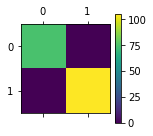

In [25]:
plot_confusion_matrix(train_conf_matrix)
print("Confusion matrix based on the performance on the whole training set")

Confusion matrix based on the performance on testing set


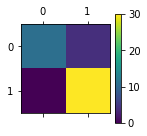

In [26]:
plot_confusion_matrix(test_conf_matrix)
print("Confusion matrix based on the performance on testing set")

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print(fpr, tpr, thresholds)

[0.         0.26666667 1.        ] [0. 1. 1.] [2 1 0]


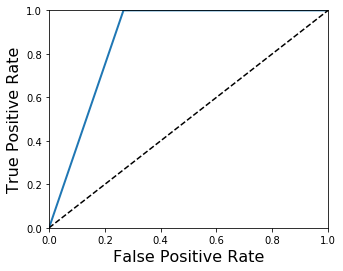

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(5, 4))
plot_roc_curve(fpr, tpr)

Now we need to train another linear model with the same configuration but now with the standard k-fold crossvalidation.

## Multiclass Classifier
***
Now we need to prepare the data for this new task of multiclass classification

First we define the keywords for each of the images we are going to gather

In [29]:
OVEREXPOSED_KEYWORDS = ["_plus_"]   # class 0
UNDEREXPOSED_KEYWORDS = ["_minus_"] # class 1
REGULAR_KEYWORDS = ["_uni_", "_0"]  # class 2
NONUNI_KEYWORDS = ["_nonuni_"]      # class 2

Then we gather each class of images into a list, and generate the corresponding label for it.

In [30]:
# defining the over-exposed images and labels
overexp_images, overexp_org_sizes = get_images_by_keywords(grayscale_data, OVEREXPOSED_KEYWORDS)
overexp_labels = generate_labels_list(len(overexp_images), 0)
# defining the under-exposed images and labels
underexp_images, underexp_org_sizes = get_images_by_keywords(grayscale_data, UNDEREXPOSED_KEYWORDS)
underexp_labels = generate_labels_list(len(underexp_images), 1)
# defining the regular images and labels
reg_images, reg_org_sizes = get_images_by_keywords(grayscale_data, REGULAR_KEYWORDS)
reg_labels = generate_labels_list(len(reg_images), 2)
# defining the non-uniform images and labels
nonuni_images, nonuni_org_sizes = get_images_by_keywords(grayscale_data, NONUNI_KEYWORDS)
nonuni_labels = generate_labels_list(len(nonuni_images), 2)
# defining length of the data
overexp_len = len(overexp_images)
underexp_len = len(underexp_images)
reg_len = len(reg_images) + len(nonuni_images)

In [31]:
print("Number of examples in over-exposed illumination pictures is: " + str(overexp_len))
print("Number of examples in under-exposed illumination pictures is: " + str(underexp_len))
print("Number of examples in regular illumination pictures is: " + str(reg_len))

Number of examples in over-exposed illumination pictures is: 60
Number of examples in under-exposed illumination pictures is: 60
Number of examples in regular illumination pictures is: 105


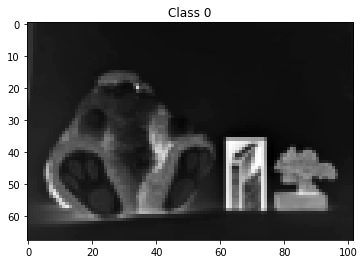

In [32]:
plot_random_image(overexp_images, overexp_labels, overexp_org_sizes)

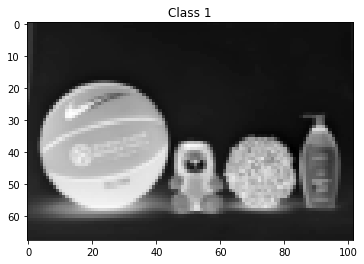

In [33]:
plot_random_image(underexp_images, underexp_labels, underexp_org_sizes)

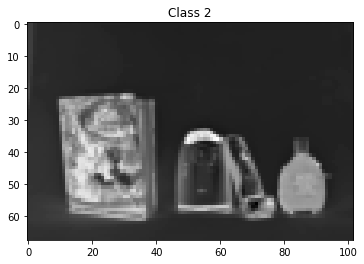

In [34]:
plot_random_image(reg_images, reg_labels, reg_org_sizes)

In [35]:
X = np.asarray(overexp_images + underexp_images + reg_images + nonuni_images)
y = np.asarray(overexp_labels + underexp_labels + reg_labels + nonuni_labels)
org_sizes = overexp_org_sizes + underexp_org_sizes + reg_org_sizes + nonuni_org_sizes

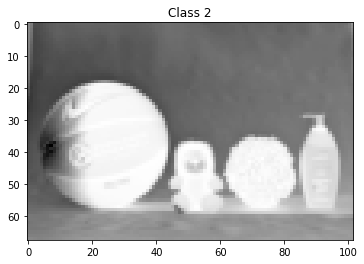

In [36]:
plot_random_image(X, y, org_sizes)

In [37]:
shuffled_X, shuffled_y = X[p], y[p]

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_y, test_size=0.2)

In [39]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovo_clf = OneVsOneClassifier(LogisticRegressionCV(max_iter=30, tol=0.01, cv=skfold, solver='liblinear', random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegressionCV(Cs=10, class_weight=None,
                                                  cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                                  dual=False,
                                                  fit_intercept=True,
                                                  intercept_scaling=1.0,
                                                  l1_ratios=None, max_iter=30,
                                                  multi_class='warn',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=42, refit=True,
                                                  scoring=None,
                                                  solver='liblinear', tol=0.01,
                                                  verbose=0),
                   n_jobs=None)

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_train_pred = ovo_clf.predict(X_train)
print('Classifier scores on the whole training set: ')
print('Accuracy is {0} '.format(accuracy_score(y_train, y_train_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_train, y_train_pred)))

Classifier scores on the whole training set: 
Accuracy is 0.9666666666666667 
And the confusion matrix: 
 [[38  0  5]
 [ 0 54  0]
 [ 1  0 82]]


In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_pred = ovo_clf.predict(X_test)
print('Classifier scores on the testing set: ')
print('Accuracy is {0} '.format(accuracy_score(y_test, y_test_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_test, y_test_pred)))

Classifier scores on the testing set: 
Accuracy is 0.8444444444444444 
And the confusion matrix: 
 [[12  0  5]
 [ 0  6  0]
 [ 2  0 20]]


In [42]:
ovr_clf = OneVsRestClassifier(LogisticRegressionCV(max_iter=30, tol=0.01, cv=skfold, solver='liblinear', random_state=42))
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=10, class_weight=None,
                                                   cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1.0,
                                                   l1_ratios=None, max_iter=30,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=42, refit=True,
                                                   scoring=None,
                                                   solver='liblinear', tol=0.01,
                                                   verbose=0),
                    n_jobs=None)

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_train_pred = ovr_clf.predict(X_train)
print('Classifier scores on the whole training set: ')
print('Accuracy is {0} '.format(accuracy_score(y_train, y_train_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_train, y_train_pred)))

Classifier scores on the whole training set: 
Accuracy is 1.0 
And the confusion matrix: 
 [[43  0  0]
 [ 0 54  0]
 [ 0  0 83]]


In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_pred = ovr_clf.predict(X_test)
print('Classifier scores on the testing set: ')
print('Accuracy is {0} '.format(accuracy_score(y_test, y_test_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_test, y_test_pred)))

Classifier scores on the testing set: 
Accuracy is 0.8222222222222222 
And the confusion matrix: 
 [[13  0  4]
 [ 0  6  0]
 [ 1  3 18]]


In [45]:
random_idx = np.random.randint(low=0, high=overexp_len-1)
overexp_img = overexp_images[random_idx]
org_size = overexp_org_sizes[random_idx]
rescaled_shape = (int(org_size[0] * RESCALING_FACTOR), int(org_size[1] * RESCALING_FACTOR)) 
print(ovo_clf.predict([overexp_img]))

[0]


In [46]:
color_images = get_all_images(DATASET_DIRNAME, RESCALING_FACTOR, RGB=True, flatten=False)

c:\users\administrator\anaconda3\envs\ottawa\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [47]:
# defining the over-exposed images and labels
overexp_images, overexp_org_sizes = get_images_by_keywords(color_images, OVEREXPOSED_KEYWORDS)
overexp_labels = generate_labels_list(len(overexp_images), 0)
# defining the under-exposed images and labels
underexp_images, underexp_org_sizes = get_images_by_keywords(color_images, UNDEREXPOSED_KEYWORDS)
underexp_labels = generate_labels_list(len(underexp_images), 1)
# defining the regular images and labels
reg_images, reg_org_sizes = get_images_by_keywords(color_images, REGULAR_KEYWORDS)
reg_labels = generate_labels_list(len(reg_images), 2)
# defining the non-uniform images and labels
nonuni_images, nonuni_org_sizes = get_images_by_keywords(color_images, NONUNI_KEYWORDS)
nonuni_labels = generate_labels_list(len(nonuni_images), 2)
# defining length of the data
overexp_len = len(overexp_images)
underexp_len = len(underexp_images)
reg_len = len(reg_images) + len(nonuni_images)

In [88]:
print("Number of examples in over-exposed illumination pictures is: " + str(overexp_len))
print("Number of examples in under-exposed illumination pictures is: " + str(underexp_len))
print("Number of examples in regular illumination pictures is: " + str(reg_len))

Number of examples in over-exposed illumination pictures is: 60
Number of examples in under-exposed illumination pictures is: 60
Number of examples in regular illumination pictures is: 105


In [148]:
def get_rgb_image_histograms(images):
    histograms = []
    for image in images:
        r_hist = image[:,:,0].ravel()
        g_hist = image[:,:,1].ravel()
        b_hist = image[:,:,2].ravel()
        
        histograms.append(r_hist + g_hist + b_hist)
    return np.asarray(histograms)

In [149]:
X = get_rgb_image_histograms(np.asarray(overexp_images + underexp_images + reg_images + nonuni_images))
y = np.asarray(overexp_labels + underexp_labels + reg_labels + nonuni_labels)

In [150]:
shuffled_X, shuffled_y = X[p], y[p]

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_y, test_size=0.2)

In [152]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovo_clf = OneVsOneClassifier(LogisticRegressionCV(max_iter=30, tol=0.01, cv=skfold, solver='liblinear', random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegressionCV(Cs=10, class_weight=None,
                                                  cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                                  dual=False,
                                                  fit_intercept=True,
                                                  intercept_scaling=1.0,
                                                  l1_ratios=None, max_iter=30,
                                                  multi_class='warn',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=42, refit=True,
                                                  scoring=None,
                                                  solver='liblinear', tol=0.01,
                                                  verbose=0),
                   n_jobs=None)

In [153]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_pred = ovo_clf.predict(X_test)
print('Classifier scores on the testing set: ')
print('Accuracy is {0} '.format(accuracy_score(y_test, y_test_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_test, y_test_pred)))

Classifier scores on the testing set: 
Accuracy is 0.9333333333333333 
And the confusion matrix: 
 [[ 9  0  1]
 [ 0  7  1]
 [ 0  1 26]]


(6936,)


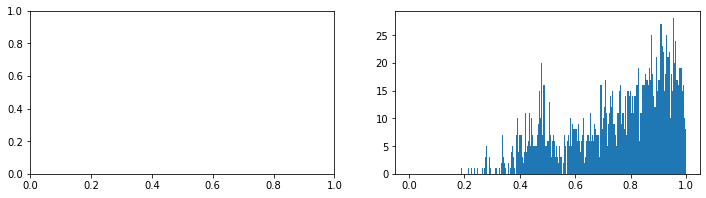

In [137]:
image = underexp_images[0]
r_hist = image[:,:,0].ravel()
g_hist = image[:,:,1].ravel()
b_hist = image[:,:,2].ravel()
print((r_hist + g_hist + b_hist).shape)
plt.subplots(1, 2, figsize=(12, 3))
# plt.hist(x=r_hist, bins=256, range=(0.0, 1.0)) #nonuni_images[0].ravel()
# plt.hist(x=g_hist, bins=256, range=(0.0, 1.0)) #nonuni_images[0].ravel()
# plt.hist(x=b_hist, bins=256, range=(0.0, 1.0)) #nonuni_images[0].ravel()
plt.hist(x=r_hist + g_hist + b_hist, bins=256, range=(0.0, 1.0)) #nonuni_images[0].ravel()
plt.show()